In [ ]:
!pip install pydicom matplotlib numpy

In [ ]:
from google.colab import drive
import os
import pydicom
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from concurrent.futures import ProcessPoolExecutor
import numpy as np
from scipy.ndimage import gaussian_filter, zoom
from skimage.segmentation import chan_vese
import pandas as pd

def mount_and_navigate_to_dir(directory_path="/content/drive/MyDrive/rsna_data/"):
    """
    Mount Google Drive and navigate to a specific directory.

    Args:
    - directory_path (str): The directory to navigate to after mounting.
    """
    ROOT = "/content/drive"
    drive.mount(ROOT, force_remount=True)
    os.chdir(directory_path)
    print(f"Current directory: {os.getcwd()}")

mount_and_navigate_to_dir()


Mounted at /content/drive
Current directory: /content/drive/MyDrive/rsna_data


In [ ]:
import os
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, zoom
from skimage.segmentation import chan_vese
import nibabel as nib
import pandas as pd


class DICOMProcessingFactory:

    def __init__(self, folder_path: str, start_idx: int, end_idx: int):
        self.folder_path = folder_path
        self.images = self._load_images(start_idx, end_idx)

    def run_functions(self, function_names, **kwargs):
        all_functions = self.get_all_functions()

        for func_name in function_names:
            if func_name in all_functions:
                print(f"Executing: {func_name}")
                all_functions[func_name](**kwargs.get(func_name, {}))
            else:
                print(f"Function {func_name} not recognized.")

    def _load_images(self, start_idx: int, end_idx: int) -> list:
        images = [[filename[:-4], pydicom.read_file(os.path.join(self.folder_path, filename))]
                  for filename in os.listdir(self.folder_path)
                  if filename.endswith('.dcm') and start_idx <= int(filename[:-4]) <= end_idx]
        images.sort(key=lambda x: x[0])
        return [img[1] for img in images]

    def invert_colors(self, invert_red=True, invert_green=True, invert_blue=True):
        img = self.images[0].pixel_array
        rgb_img = np.stack((img,)*3, axis=-1)

        if invert_red:
            rgb_img[:,:,0] = np.max(img) - rgb_img[:,:,0]
        if invert_green:
            rgb_img[:,:,1] = np.max(img) - rgb_img[:,:,1]
        if invert_blue:
            rgb_img[:,:,2] = np.max(img) - rgb_img[:,:,2]

        plt.imshow(rgb_img)
        plt.show()


    def save_as_png(self, img, save_path):
        plt.imsave(save_path, img, cmap=plt.cm.bone)

    def adjust_brightness_contrast(self, brightness=0, contrast=1):
        img = self.images[0].pixel_array.astype(np.float32)

        img += brightness
        mean = np.mean(img)
        img = (img - mean) * contrast + mean


        img = np.clip(img, 0, 255).astype(np.uint8)

        plt.imshow(img, cmap=plt.cm.bone)
        plt.show()

    def resample_image(self, img, new_shape=(256, 256, 10)):

        resample_factors = [ns/float(is_) for ns, is_ in zip(new_shape, img.shape)]
        return zoom(img, resample_factors)

    def gamma_correction(self, img, gamma=1.0):

        if gamma == 0:
            print("Gamma value shouldn't be zero.")
            return

        normalized_img = img / 255.0
        corrected_img = np.power(normalized_img, gamma)
        corrected_img = (corrected_img * 255).astype(np.uint8)

        return corrected_img


    def dicom_contrast_correction(self, img, lower_bound, upper_bound):
        # Do not access the first image from self.images here
        # Instead, process the provided img parameter
        img = img.astype(np.int16)

        intercept = self.images[0].RescaleIntercept  # This should be adjusted if the RescaleIntercept varies between images
        slope = self.images[0].RescaleSlope  # This should be adjusted if the RescaleSlope varies between images
        img = slope * img + intercept
        img = np.clip(img, lower_bound, upper_bound)
        img = (img - intercept) / slope
        img = img.astype(np.uint16)

        return img

    def save_all_images_as_png(self, mode='gamma', gamma=1.0, lower_bound=None, upper_bound=None, save_dir='.'):

        os.makedirs(save_dir, exist_ok=True)

        for idx, dicom_img in enumerate(self.images):
            resampled_img = self.resample_image(dicom_img.pixel_array, new_shape=(256, 256, 10))
            if mode == 'gamma':
                corrected_img = self.gamma_correction(resampled_img, gamma)

            elif mode == 'dicom_contrast':
                if lower_bound is None or upper_bound is None:
                    raise ValueError("Both lower_bound and upper_bound must be provided for dicom_contrast mode.")
                corrected_img = self.dicom_contrast_correction(resampled_img, lower_bound, upper_bound)
            else:
                raise ValueError(f"Unknown mode {mode}. Choose between 'gamma' and 'dicom_contrast'.")

            save_path = os.path.join(save_dir, f"{mode}_corrected_resampled_image_{idx}.png")
            plt.imsave(save_path, corrected_img, cmap=plt.cm.bone)
            print(f"Saved: {save_path}")


In [ ]:
# # Initializing the DICOMProcessingFactory with a folder path and range of file indices
folder_path = 'rsna_data/train_images/10004/21057'
# start_idx = 0
# end_idx = 1000
factory = DICOMProcessingFactory(folder_path, start_idx, end_idx)

# # 1. Saving all images using gamma correction
# gamma_value = 0.5
# save_directory_gamma = 'png_test'
# factory.save_all_images_as_png(mode='gamma', gamma=gamma_value, save_dir=save_directory_gamma)

# 2. Saving all images using DICOM contrast correction-1200, -500
lower_bound_value = -1200
upper_bound_value =  -500
save_directory_dicom_contrast = 'png_test'
factory.save_all_images_as_png(mode='dicom_contrast', lower_bound=lower_bound_value, upper_bound=upper_bound_value, save_dir=save_directory_dicom_contrast)

In [ ]:
!ls

'Colab Notebooks'   png_test   rsna_data   test


In [ ]:
dicom_processor = DICOMProcessingFactory(folder_path='rsna_data/train_images/10004/21057', start_idx=0, end_idx=1000)
dicom_processor.save_all_images_as_png(gamma=0.6, save_dir='/png_test/')

# **버려진 함수모음**

In [ ]:
import os
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, zoom
from skimage.segmentation import chan_vese
import nibabel as nib
import pandas as pd


class DICOMProcessingFactory:

    def __init__(self, folder_path: str, start_idx: int, end_idx: int):
        self.folder_path = folder_path
        self.images = self._load_images(start_idx, end_idx)

    # def _load_images(self, start_idx: int, end_idx: int) -> list:
    #     images = [[filename[:-4], pydicom.read_file(os.path.join(self.folder_path, filename))]
    #               for filename in os.listdir(self.folder_path)
    #               if filename.endswith('.dcm') and start_idx <= int(filename[:-4]) <= end_idx]

    #     images = sorted(images, key=lambda x: int(x[0]))
    #     return [img[1] for img in images]

    def run_functions(self, function_names, **kwargs):
        all_functions = self.get_all_functions()

        for func_name in function_names:
            if func_name in all_functions:
                print(f"Executing: {func_name}")
                all_functions[func_name](**kwargs.get(func_name, {}))
            else:
                print(f"Function {func_name} not recognized.")

    def _load_images(self, start_idx: int, end_idx: int) -> list:
        images = [[filename[:-4], pydicom.read_file(os.path.join(self.folder_path, filename))] for filename in os.listdir(self.folder_path) if filename.endswith('.dcm') and start_idx <= int(filename[:-4]) <= end_idx]
        images = sorted(images, key=lambda x: x[0])
        return [img[1] for img in images]

    def invert_colors(self, invert_red=True, invert_green=True, invert_blue=True):
        img = self.images[0].pixel_array
        rgb_img = np.stack((img,)*3, axis=-1)

        if invert_red:
            rgb_img[:,:,0] = np.max(img) - rgb_img[:,:,0]
        if invert_green:
            rgb_img[:,:,1] = np.max(img) - rgb_img[:,:,1]
        if invert_blue:
            rgb_img[:,:,2] = np.max(img) - rgb_img[:,:,2]

        plt.imshow(rgb_img)
        plt.show()

    def save_as_png(self, img, save_path):
        plt.imsave(save_path, img, cmap=plt.cm.bone)

    def adjust_brightness_contrast(self, brightness=0, contrast=1):
        img = self.images[0].pixel_array.astype(np.float32)

        # Adjust brightness
        img += brightness

        # Adjust contrast
        mean = np.mean(img)
        img = (img - mean) * contrast + mean

        # Clip values to prevent overflow or underflow
        img = np.clip(img, 0, 255).astype(np.uint8)

        plt.imshow(img, cmap=plt.cm.bone)
        plt.show()

    def resample_image(self, img, new_shape=(256, 256, 10)):
        """
        Resample the given image to the specified shape.
        """
        # Calculate the resampling factor for each dimension
        resample_factors = [ns/float(is_) for ns, is_ in zip(new_shape, img.shape)]
        return zoom(img, resample_factors)

    def gamma_correction(self, img, gamma=1.0):
        # Ensure gamma is not zero
        if gamma == 0:
            print("Gamma value shouldn't be zero.")
            return

        img = self.images[0].pixel_array.astype(np.float32)

        # Normalize the image to [0, 1]
        normalized_img = img / 255.0

        # Apply gamma correction
        corrected_img = np.power(normalized_img, gamma)

        # Rescale to [0, 255]
        corrected_img = (corrected_img * 255).astype(np.uint8)

        return corrected_img

    def dicom_contrast_correction(self, lower_bound, upper_bound):
        """
        Adjust the DICOM pixel values to increase the contrast based on HU.
        Pixel values below the lower bound will be set to the lower bound.
        Pixel values above the upper bound will be set to the upper bound.
        """
        img = self.images[0].pixel_array.astype(np.int16)

        # Convert the DICOM pixel data to Hounsfield units
        intercept = self.images[0].RescaleIntercept
        slope = self.images[0].RescaleSlope
        img = slope * img + intercept

        # Apply contrast correction
        img = np.clip(img, lower_bound, upper_bound)

        # Convert back to original pixel values after windowing
        img = (img - intercept) / slope
        img = img.astype(np.uint16)

        plt.imshow(img, cmap=plt.cm.bone)
        plt.show()

    def save_all_images_as_png(self, gamma=1.0, save_dir='.'):
        """
        Save all loaded DICOM images after resampling and gamma correction as PNG files.
        """
        for idx, dicom_img in enumerate(self.images):
            # Resample the image first
            resampled_img = self.resample_image(dicom_img.pixel_array, new_shape=(256, 256, 10))

            # Apply gamma correction
            # corrected_img = self.gamma_correction(gamma, img=resampled_img)
            corrected_img = self.gamma_correction(resampled_img, gamma)
            save_path = os.path.join(save_dir, f"corrected_resampled_image_{idx}.png")
            plt.imsave(save_path, corrected_img, cmap=plt.cm.bone)
            print(f"Saved: {save_path}")


In [ ]:
    def windowing(self, level, width):
        img = self.images[0].pixel_array
        min_val = level - width // 2
        max_val = level + width // 2
        img = np.clip(img, min_val, max_val)
        plt.imshow(img, cmap=plt.cm.bone)
        plt.show()

    def aortic_windowing(self, series_id, csv_path='train_series_meta.csv'):
        df = pd.read_csv(csv_path)

        aortic_values = df[df['series_id'] == series_id]['aortic_hu'].values

        if len(aortic_values) == 0:
            print(f"Patient ID {series_id} not found in the CSV file.")
            return

        aortic_hu = aortic_values[0]
        print(aortic_hu)
        self.windowing(aortic_hu, 200)

    def resample(self, new_spacing=(1,1)):
        img = self.images[0].pixel_array
        resample_factor = np.array(self.images[0].PixelSpacing) / new_spacing
        resampled_img = zoom(img, resample_factor)
        plt.imshow(resampled_img, cmap=plt.cm.bone)
        plt.show()

    def noise_reduction(self, sigma=1):
        img = self.images[0].pixel_array
        smoothed_img = gaussian_filter(img, sigma=sigma)
        plt.imshow(smoothed_img, cmap=plt.cm.bone)
        plt.show()

    def padding_or_cropping(self, desired_shape=(512, 512)):
        img = self.images[0].pixel_array
        pad_before_x = (desired_shape[0] - img.shape[0]) // 2
        pad_after_x = desired_shape[0] - pad_before_x - img.shape[0]
        pad_before_y = (desired_shape[1] - img.shape[1]) // 2
        pad_after_y = desired_shape[1] - pad_before_y - img.shape[1]

        padded_img = np.pad(img, ((pad_before_x, pad_after_x), (pad_before_y, pad_after_y)))
        plt.imshow(padded_img, cmap=plt.cm.bone)
        plt.show()

    def normalization(self):
        img = self.images[0].pixel_array
        normalized_img = (img - np.min(img)) / (np.max(img) - np.min(img))
        plt.imshow(normalized_img, cmap=plt.cm.bone)
        plt.show()

    def get_all_functions(self):

        return {
            'aortic_windowing': self.aortic_windowing,
            'resample': self.resample,
            'noise_reduction': self.noise_reduction,
            'padding_or_cropping': self.padding_or_cropping,
            'normalization': self.normalization,
            'invert_colors': self.invert_colors  # Adding the new function to the dictionary
        }


# **이미지 출력 사진 모음**

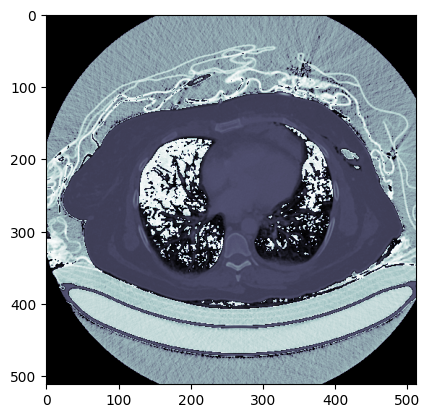

In [ ]:
dicom_processor = DICOMProcessingFactory('train_images/10004/21057', 300, 500)
dicom_processor.gamma_correction(0.2)

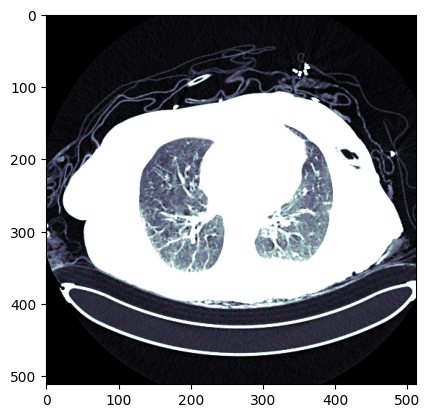

In [ ]:
dicom_processor = DICOMProcessingFactory('train_images/10004/21057', 300, 500)
dicom_processor.dicom_contrast_correction(-1200, -500)

Executing: invert_colors


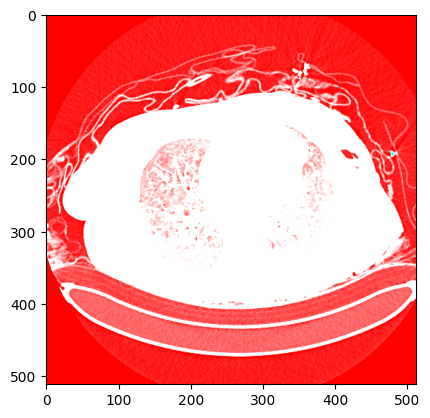

In [ ]:
# Sample usage
dicom_processor = DICOMProcessingFactory('train_images/10004/21057', 300, 350)
dicom_processor.run_functions(['invert_colors'], invert_colors={'invert_red': True, 'invert_green': False, 'invert_blue': False})
# dicom_processor.resample()
# dicom_processor.padding_or_cropping()
# dicom_processor.normalization()
# dicom_processor.noise_reduction()
# dicom_processor.aortic_windowing(21057)

Executing: aortic_windowing
146.0


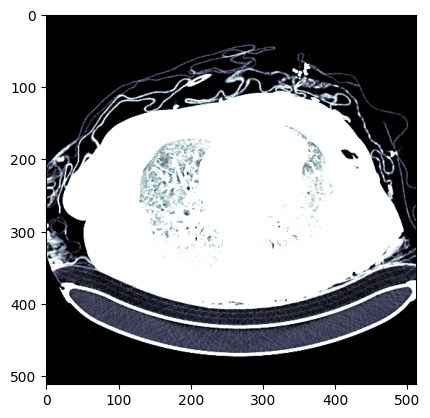

Executing: resample


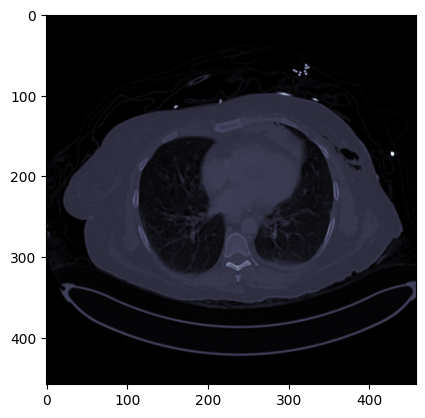

Executing: noise_reduction


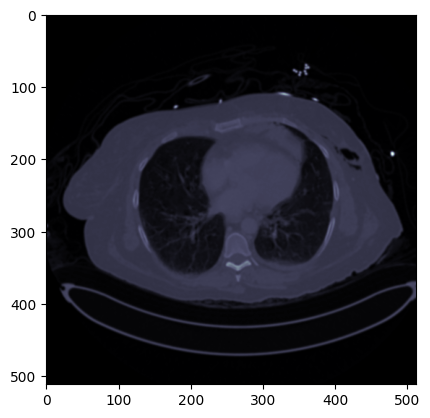

Executing: padding_or_cropping


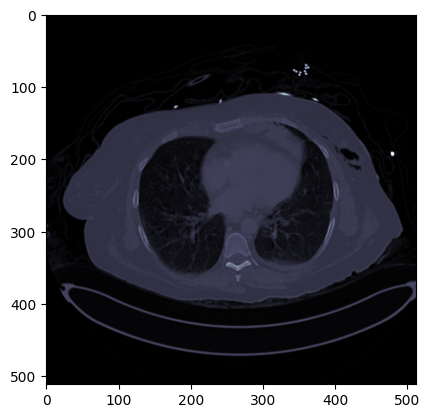

Executing: normalization


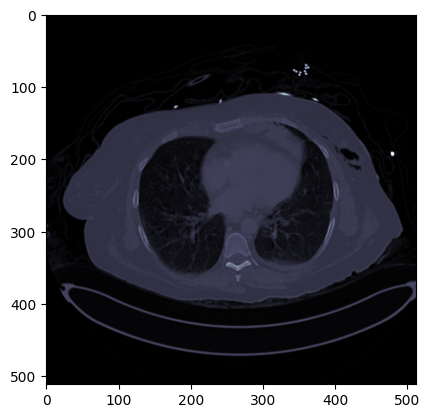

In [ ]:
folder_path = 'train_images/10004/21057' # adjust this path accordingly
start_index = 300
end_index = 500
series_id_example = 21057 # provide a valid series_id that exists in the 'train_series_meta.csv'

processor = DICOMProcessingFactory(folder_path, start_index, end_index)
all_function_names = list(processor.get_all_functions().keys())
kwargs = {
    'aortic_windowing': {'series_id': series_id_example}
}
processor.run_functions(all_function_names, **kwargs)